In [14]:
import os
import glob
from pathlib import Path
import polars as pl
import re
import gzip
import sys
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lxml import etree, objectify
from rapidfuzz import fuzz
from spacy import displacy

import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.topic_extractor as topic_extractor
import infineac.process_text as process_text

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
random.seed(111)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load NLP model

In [179]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")
nlp_stanza.add_pipe('sentencizer')

2023-08-28 19:15:12 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-28 19:15:14 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-08-28 19:15:14 WARNING: GPU requested, but is not available!
2023-08-28 19:15:14 INFO: Using device: cpu
2023-08-28 19:15:14 INFO: Loading: tokenize
2023-08-28 19:15:14 INFO: Loading: lemma
2023-08-28 19:15:14 INFO: Done loading processors!


## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [16]:
# files = [Path("../data/transcripts/2022/15203138_T.xml")]
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files[0:1000])

Files: 100%|██████████| 1000/1000 [00:01<00:00, 644.82it/s]


Check if all positions are valid

In [17]:
process_event.test_positions(events)

## Filter data

Filter out all events that are not in the given time range and do not include the given keywords.

In [101]:
events_filt_all = process_event.filter_events(events, year = 2022, keywords = {"russia":1, "ukraine":1}, modifier_words=[])
events_filt = process_event.filter_events(events, year = 2022, keywords = {"russia":1, "ukraine":1})
len(events_filt)

Filtering events


Events: 100%|██████████| 1000/1000 [00:00<00:00, 1607.99it/s]


Filtering events


Events: 100%|██████████| 1000/1000 [00:04<00:00, 205.38it/s]


237

In [ ]:
helper.save_data(events_filt, "events_filt", compression="lz4")

List all events, that are filtered out due to modifier words preceding the keywords.

In [20]:
events_filtered_filter_words = []
ids_filtered_events = []
for i, event in enumerate(events_filt):
    ids_filtered_events.append(event['id'])
for event in events_filt_all:
    if event['id'] not in ids_filtered_events:
        events_filtered_filter_words.append(event)
print(len(events_filtered_filter_words))
process_event.extract_passages_from_events(events_filtered_filter_words, keywords=["russia", "ukraine"], modifier_words=[], nlp=nlp_stanza)

0
Extracting paragraphs from events


Events: 0it [00:00, ?it/s]


[]

## Exploration

In [ ]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company = [event['company_name'] for event in events_filt]
ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
numeric_values = mdates.date2num(dates)

russia_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

Create a DataFrame with the following columns:

In [ ]:
df = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company': company,
                   'ticker':ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'dates_num' : numeric_values,
                   'russia': russia_and_sanction,
                   'russia_count': russia_count,
                   'sanction_count': sanction_count,
                   'election': election})

Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

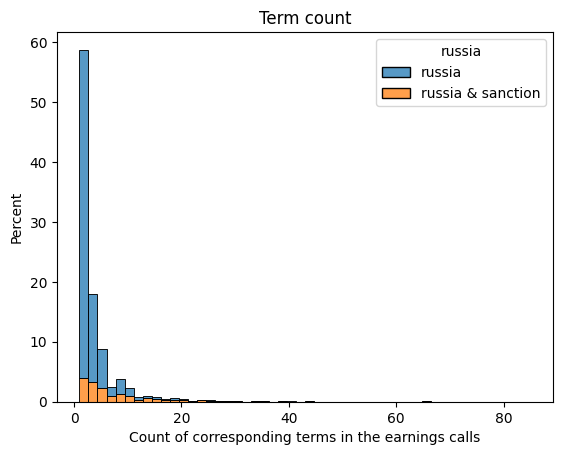

In [ ]:
sns.histplot(df[df['russia_count']>=1], x='russia_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [ ]:
np.array(russia_count).mean()

2.7451327433628316

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [ ]:
np.array([el for el in russia_count if el > 0]).mean()

3.8724289620734753

Average mentions of "sanction" per earnings call.

In [ ]:
np.array([el for el in sanction_count if el > 0]).mean()

2.4227877385772123

Event distribution over time highlighting the different categories.

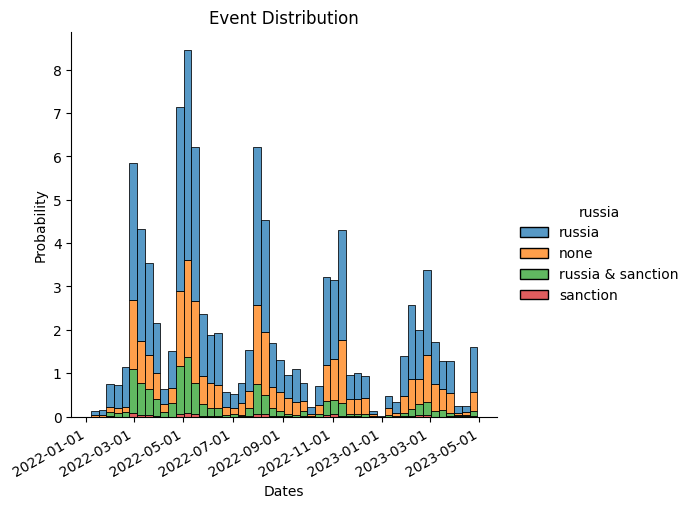

In [ ]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

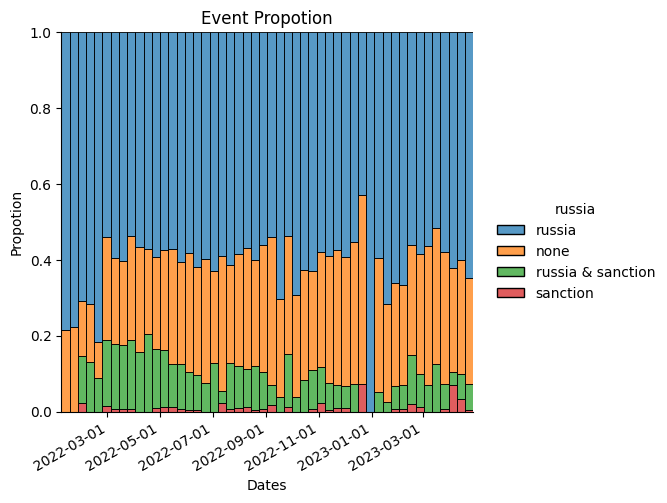

In [ ]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Propotion')
plt.title('Event Propotion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

## Preprocess and extract the Corpus

In [289]:
corpus_window_0_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=False,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)

Extracting paragraphs from events


Events: 100%|██████████| 237/237 [00:41<00:00,  5.76it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 1026/1026 [00:43<00:00, 23.46it/s]


In [290]:
corpus_window_0_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_0_join_df)

Extracting paragraphs from events


Events: 100%|██████████| 237/237 [00:59<00:00,  4.00it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 933/933 [00:54<00:00, 17.23it/s]


933

In [291]:
corpus_window_3_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=3,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_3_join_df)

Extracting paragraphs from events


Events: 100%|██████████| 237/237 [00:40<00:00,  5.87it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 876/876 [00:50<00:00, 17.30it/s]


876

In [292]:
corpus_window_5_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=5,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_5_join_df)

Extracting paragraphs from events


Events: 100%|██████████| 237/237 [00:36<00:00,  6.52it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 870/870 [00:50<00:00, 17.39it/s]


870

In [311]:
corpus_window_5_join_par_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=5,
    subsequent_paragraphs=1,
    join_adjacent_sentences=True,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_5_join_par_df)

Extracting paragraphs from events


Events: 100%|██████████| 237/237 [00:35<00:00,  6.61it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 1340/1340 [01:32<00:00, 14.51it/s]


1340

In [312]:
helper.save_data(corpus_window_0_df, "corpus_window_0_df", compression="lz4")
helper.save_data(corpus_window_0_join_df, "corpus_window_0_join_df", compression="lz4")
helper.save_data(corpus_window_3_join_df, "corpus_window_3_join_df", compression="lz4")
helper.save_data(corpus_window_5_join_df, "corpus_window_5_join_df", compression="lz4")
helper.save_data(corpus_window_5_join_par_df, "corpus_window_5_join_par_df", compression="lz4")

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

In [189]:
lengths = [len(doc) for doc in corpus_window_0_df['text_processed'].to_list()]
np.argmax(np.array(lengths))

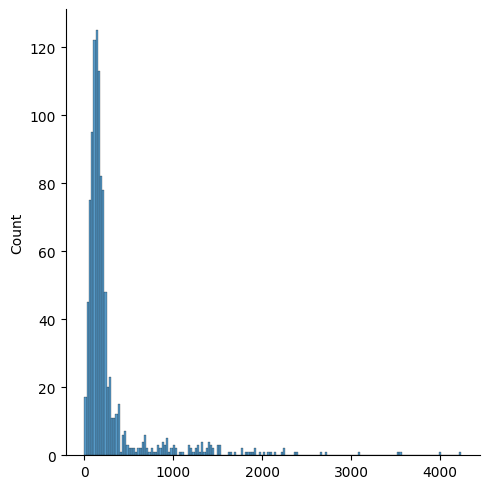

In [191]:
sns.displot(np.array(lengths))

In [223]:
nlp_stanza.Defaults.stop_words |= {"want", "russia", "ukraine"}

In [243]:
doc_nlp = nlp_stanza(corpus_window_0_list[0])
doc_nlp

I want to begin my remarks today by acknowledging the tragic events happening in Ukraine and the resulting humanitarian crisis.

In [252]:
print(doc_nlp[14])
doc_nlp[14].is_stop

Ukraine


False

In [256]:
docs = process_text.process_corpus(corpus_window_0_list, nlp_stanza, remove_additional_words=["russia", "ukraine"])

Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 1026/1026 [00:28<00:00, 35.93it/s]


In [258]:
docs_join = [process_text.list_to_string(doc) for doc in docs]

In [280]:
topic_model, topics, probs = topic_extractor.bert_inspired(corpus_window_0_df['processed_text'].to_list())

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

2023-08-28 23:13:34,008 - BERTopic - Transformed documents to Embeddings
2023-08-28 23:13:38,543 - BERTopic - Reduced dimensionality
2023-08-28 23:13:38,631 - BERTopic - Clustered reduced embeddings


In [261]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,498,-1_demand_market_production_revenue,"[demand, market, production, revenue, business...",[thanks question substitution russian gas thin...
1,0,108,0_demand_production_industry_market,"[demand, production, industry, market, supply,...",[right great way good morning richard great wa...
2,1,72,1_war_peace_military_geopolitical,"[war, peace, military, geopolitical, conflict,...","[term war, get war, see war]"
3,2,70,2_petroleum_diesel_refinery_gas,"[petroleum, diesel, refinery, gas, refiner, oi...","[know country expose russian gas import, russi..."
4,3,39,3_covid_china_shortage_pandemic,"[covid, china, shortage, pandemic, economy, mi...",[great uncertainty macro environment include i...
5,4,38,4_macroeconomic_inflation_inflationary_economy,"[macroeconomic, inflation, inflationary, econo...",[guidance base current market condition change...
6,5,32,5_billion_revenue_belarus_russian,"[billion, revenue, belarus, russian, impact, a...",[look let course look carefully lot interest e...
7,6,30,6_geopolitical_invasion_russian_conflict,"[geopolitical, invasion, russian, conflict, wa...",[look performance past month key external fact...
8,7,29,7_henry_henri_alfred_cristian,"[henry, henri, alfred, cristian, emanuele, bru...",[thanks mehdi follow question question raphaël...
9,8,25,8_ebitda_ebit_revenue_business,"[ebitda, ebit, revenue, business, billion, mil...",[finally mention year revenue guidance exclude...


In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs_join, calculate_tokens=True)

In [ ]:
topic_model.visualize_distribution(topic_distr[1])

In [ ]:
# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(docs_join[1], topic_token_distr[1])
df

In [ ]:
topic_model.get_topic(0)

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
sentence1 = "Now this slide talks more about the immediate impact where the combination of sanctions and also business destruction in Ukraine leads or may lead to supply chain disruptions."
sentence2 = "We obviously intensively evaluate all the potential impacts, created a task force that meets almost daily to follow on these topics and basically do preventive measures as to limit the potential impact on CEZ."

doc1 = nlp(sentence1)
doc2 = nlp(sentence2)
similarity = doc1.similarity(doc2)

sentences_ = [sentence1, sentence2]
sentence_embeddings = model.encode(sentences_)

print("Cosine Similarity: " + str(util.pytorch_cos_sim(sentence_embeddings[0], sentence_embeddings[1]).item()))
print("similiarity: " + str(similarity))

In [ ]:
# import dill as pickle
# pickle.dump(events_russia, open('../output/pickled/events_russia.pkl', 'wb'))
# pickle.dump(events, open('../output/pickled/events.pkl', 'wb'))

In [ ]:
docs = [event['presentation_collapsed'] + "\n" + event['qa_collapsed'] for event in events_russia]

In [ ]:
df.to_csv('../output/data/overview.csv', index=False)

In [ ]:
#  df[['company', 'ticker', 'ticker_new', 'date', 'russia', 'russia_count', 'sanction_count']].to_csv('../output/data/overview_jakob.csv', index=False)
# with open('../output/data/overview_jakob.csv', 'rb') as f_in:
#     with gzip.open('../output/data/overview_jakob.csv.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

Create 15 samples for each category: russia and election and save it in the
corresponding directory.

In [ ]:
if len(df[df['russia'] == 'russia & sanctions']) >0:sample_files_russia = df[df['russia'] == 'russia'].sample(8)['file'].tolist() + df[df['russia'] == 'russia & sanctions'].sample(7)['file'].tolist()
if len(df[df['election'] == 'presidential election']) >0: sample_files_election = df[df['election'] == 'presidential election'].sample(15)['file'].tolist()

In [ ]:
# delete all files in folder
if 'sample_files_russia' in locals() or 'sample_files_russia' in globals():
    folder = '../output/sample transcripts/russia/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_russia:
        shutil.copy(file, folder)

In [ ]:
# delete all files in folder
if 'sample_files_election' in locals() or sample_files_election in globals():
    folder = '../output/sample transcripts/election/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_election:
        shutil.copy(file, folder)

Polars

In [ ]:
keys_to_keep = ['file', 'body_orig']

In [ ]:
events_new_trimmed = [{key: event[key] for key in keys_to_keep} for event in events_new]

In [ ]:
eventsDF = pl.from_dicts(events_new_trimmed)

In [ ]:
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(E|e)lections').alias("elections_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(S|s)anctions').alias("sanctions_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(R|r)ussia').alias("russia_count"))

In [ ]:
len(eventsDF.filter(pl.col("elections_count") > 0))

In [ ]:
len(eventsDF.filter((pl.col("sanctions_count") > 0) & (pl.col("russia_count") > 0)))